In [1]:
from collections import defaultdict
import math
import numpy as np
from numpy import ma
import datetime, time
from datetime import datetime
import netCDF4
from netCDF4 import Dataset, num2date
from scipy.interpolate import griddata
from scipy.spatial import Delaunay


import TomTom
import TomTom.Mesh_maker as Mesh_maker
import TomTom.Functions as Functions
import TomTom.Calc_path as Calc_path


import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

import os
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# User defined values

In [2]:
class flow_potentiaalveld():
    def __init__(self, name):
        d = datetime.strptime("23/03/2019 00:00:00", "%d/%m/%Y %H:%M:%S")
        t0 = d.timestamp() 
        x = np.arange(0,1,0.025)
        y = np.arange(0,1,0.025)
        t = np.arange(t0, (t0+60*10000),10*60)

        y, x = np.meshgrid(y, x)
        y = y.reshape(y.size)
        x = x.reshape(y.size)

        nodes = np.zeros((len(x),2))
        nodes[:,0] = y
        nodes[:,1] = x
        tria = Delaunay(nodes)

        u = []
        v = []
        for node in nodes:
            ut = 0*t + 2 * np.cos(np.pi*(node[0]))
            vt = 0*t - 2 * np.cos(np.pi*(node[1]))
            u.append(ut)
            v.append(vt)
        
        self.v = np.transpose(np.array(v))
        self.u = np.transpose(np.array(u))
        self.WD = self.u*0 + 20
        self.t = t
        self.nodes = nodes
        self.tria = Delaunay(nodes)

class flow_dyn_cur():
    def __init__(self, name):
        d = datetime.strptime("23/03/2019 00:00:00", "%d/%m/%Y %H:%M:%S")
        t0 = d.timestamp() 
        x = np.arange(0,1,0.01)
        y = np.arange(0,1,0.01)
        t = np.arange(t0, (t0+60*10000),10*60)

        y, x = np.meshgrid(y, x)
        y = y.reshape(y.size)
        x = x.reshape(y.size)

        nodes = np.zeros((len(x),2))
        nodes[:,0] = y
        nodes[:,1] = x
        tria = Delaunay(nodes)

        u = []
        v = []
        for node in nodes:
            ut =   2 * np.cos(np.pi*(node[0])) * np.cos(2*np.pi * (t - t0)/24000)
            vt = - 2 * np.cos(np.pi*(node[1]))* np.cos(2*np.pi * (t - t0)/24000)
            u.append(ut)
            v.append(vt)
        
        self.v = np.transpose(np.array(v))
        self.u = np.transpose(np.array(u))
        self.WD = self.u*0 + 20
        self.t = t
        self.nodes = nodes
        self.tria = Delaunay(nodes)

        
class flow_wait():
    def __init__(self, name):
        d = datetime.strptime("23/03/2019 00:00:00", "%d/%m/%Y %H:%M:%S")
        t0 = d.timestamp() 
        x = np.arange(3,4,0.05)
        y = np.arange(50,51,0.05)
        t = np.arange(t0, (t0+60*10000),10*60)

        y, x = np.meshgrid(y, x)
        y = y.reshape(y.size)
        x = x.reshape(y.size)

        nodes = np.zeros((len(x),2))
        nodes[:,0] = y
        nodes[:,1] = x
        tria = Delaunay(nodes)

        u = []
        v = []
        for node in nodes:
            ut = 0*t + 0
            vt = 0*t + 0
            u.append(ut)
            v.append(vt)
            
        self.v = np.transpose(np.array(v))
        self.u = np.transpose(np.array(u))
        self.t = t
        self.nodes = nodes
        self.tria = Delaunay(nodes)
        
        WD = self.u*0 + 20
        for i in range(len(nodes)):
            node = nodes[i]
            if node[0] > 50.4 and node[0] < 50.6:
                WD[5:100,i] = 0
        self.WD = WD

In [3]:
nl = (3,2.5)
dx_min = 0.01
blend = 1
number_of_neighbor_layers = 3
Load_flow = flow_dyn_cur

vship = np.array([4])
WD_min = 1.4

name_textfile_flow = 'maaktnietuit'

In [4]:
start_time = time.time()

Roadmap = Mesh_maker.Graph_flow_model(name_textfile_flow, 
                                    dx_min, 
                                    blend, 
                                    nl, 
                                    number_of_neighbor_layers, 
                                    vship, 
                                    Load_flow, 
                                    WD_min
                                   )

#TomTom.save_object(Roadmap, name_textfile_save)

stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

1/4
2/4
3/4
0 1
4/4
the computational time is: 350.74 sec


# Plots

In [5]:
t0 = "23/03/2019 03:00:00"          #Departure time

start = (0.1, 0.1)
stop = (0.9, 0.9)
vship = 1

vv = np.abs(Roadmap.vship - vship)
arg_vship = int(np.argwhere(vv == vv.min()))
print("V_ship = ", Roadmap.vship[arg_vship])

class graph_functions_time:
    function_type = "time optimalisation"
    weights = Roadmap.weight_time[arg_vship].weights
    time = Roadmap.weight_time[arg_vship].weights
    
route_time = Calc_path.Has_route(start, stop, Roadmap, t0, graph_functions_time)

V_ship =  4


In [6]:
x_r = np.arange(0,1, 0.075)
y_r = np.arange(0,1, 0.075)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = griddata((Roadmap.flow.nodes[:,1], Roadmap.flow.nodes[:,0]), Roadmap.flow.WD[0], (x_r, y_r), method= 'linear')
u_r = griddata((Roadmap.flow.nodes[:,1], Roadmap.flow.nodes[:,0]), Roadmap.flow.u[0], (x_r, y_r), method= 'linear')
v_r = griddata((Roadmap.flow.nodes[:,1], Roadmap.flow.nodes[:,0]), Roadmap.flow.v[0], (x_r, y_r), method= 'linear')

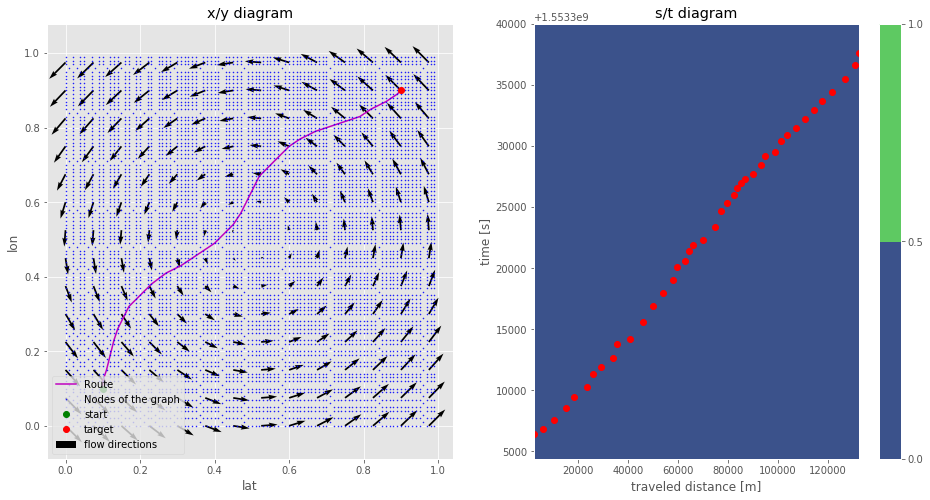

In [7]:
fig = plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.axis('equal')
a = 1

#plt.contourf(x_r,y_r,WD_r)

plt.quiver(x_r[::a,::a],
           y_r[::a,::a],
           u_r[::a,::a],
           v_r[::a,::a],
           label = 'flow directions'
          )
plt.plot(route_time.x_route, route_time.y_route, 'm', label = 'Route')
plt.plot(Roadmap.nodes[:,1], Roadmap.nodes[:,0], 'b.', label = 'Nodes of the graph', markersize = 1)
plt.plot(route_time.x_route[0], route_time.y_route[0], 'go', label = 'start')
plt.plot(route_time.x_route[-1], route_time.y_route[-1], 'ro', label = 'target')


#plt.xlim(start[1] - 0.1, stop[1] + 0.1)
#plt.ylim(start[0] - 0.1, stop[0] + 0.1)
plt.title('x/y diagram')
plt.legend(loc = 'best')
plt.xlabel('lat')
plt.ylabel('lon')

plt.subplot(1,2,2)
TomTom.plot_timeseries(route_time, Roadmap)
plt.title('s/t diagram')

plt.savefig('Testcase_dyn_cur')

plt.show()